To install rascal:
(NOTE: See the top-level README for the most up-to-date installation instructions.)
+ mkdir ../build 
+ cd build
+ cmake -DCMAKE_BUILD_TYPE=Release -DBUILD_TESTS=ON ..
+ make -j 4
+ make install

# Setup

In [1]:
%matplotlib notebook
from matplotlib import pylab as plt
import time
import json

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
import sys
#import pandas
import scipy
import json
import sklearn

In [2]:
import os, sys
# Ensure the notebook is running in the proper directory
# (only needed when compiling from sphinx)
if "docs/source/tutorials" in os.getcwd():
    os.chdir("../../../examples")
sys.path.insert(0,"../build/")
from rascal.representations import SphericalInvariants as SOAP

In [103]:
download_link = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-018-06972-x/MediaObjects/41467_2018_6972_MOESM4_ESM.txt"
import urllib.request
urllib.request.urlretrieve(download_link, './data/CSD-500.xyz')
frames = read('./data/CSD-500.xyz','0:10')
# wraps the structures into the unit cell
for i in range(len(frames)):
    frames[i].wrap(eps=1e-11)
print(frames[0])

URLError: <urlopen error [Errno -2] Name or service not known>

To compare position representations of environments $<r|X_i>$ and $<r|X_j>$ a statistical distance is required $d_(<r|X_i>,<r|X_j>)$. This can be the L2 norm distance

$d_{L2}(<r|X_i>,<r|X_j>) = \int \|<r|X_i> - <r|X_j>\|_2\mathrm{d}\,r$

which is not smooth. A solution for this is the proposed by using the earth mover distance/wasserstein metric
$d_{emd}(<r|X_i>,<r|X_j>) = \int \|icdf(<r|X_i>) - icdf(<r|X_j>)\|_2\mathrm{d}\,r,$
where $icdf$ is the inverted cumulative distance. Because it fulfills the smoothness it should give better results. We will find out if it does.

We need
$<r|X_i> = \sum_{n\alpha} <n\alpha|X_i> \tilde{R}_n(r)$, 

- where $<n\alpha|X_i>$ is the output of the SOAP vector

- $\tilde{R}_n(r)$ is the normalized basis function with the the jacobian determinant, if you compare with the SOAP derivation it is $R_n(r)r$ normalized.

In [10]:
# This part computes \tilde{R}(r)
from scipy.special import gamma
from scipy import integrate

# N_n
def orthogonal_normalization(n, sigma):
    return np.sqrt( 2/(sigma**(2*n+3) *gamma(n+3/2)) )

# (S_nndash)^(-1/2)
def orthonormalization(n, b, N, sigma):
    ndash = n[:,np.newaxis]
    bdash = b[:,np.newaxis]
    sigmadash = sigma[:,np.newaxis]
    Ndash = N[:,np.newaxis]
    overlap = 0.5*N*Ndash*(b+bdash)**(-0.5*(3+n+ndash))*gamma(0.5*(3+n+ndash))
    return scipy.linalg.fractional_matrix_power(overlap,-0.5)
    
# R_n(r)*r
def gaussian_sigma_constant(N, b, n, r):
    return N * r**(n+1) * np.exp(-b*r**2)

# \tilde{R}_n(r)
def gto_basis_constant_function(max_n, cutoff):
    n = np.arange(max_n)
    sigma = np.sqrt(np.hstack((1,np.arange(1,max_n)))) * cutoff / max_n
    N = orthogonal_normalization(n, sigma)
    b = 1/(2*sigma)
    Snorm = orthonormalization(n, b, N, sigma)
    return lambda r : gaussian_sigma_constant(N, b, n, r).dot(Snorm)

#########
# Tests #
#########
max_n = 6
# the whole set of orthonormalized basis functions
bf = gto_basis_constant_function(max_n, 3.5)
# the nth orthornormal basis function
bf_4 = lambda r: bf(r)[4]
# all orthonormalized basis function for r=5
print(bf(5).size)
# the orthonormalized basis function n=4 for r=8
print(bf_4(8))
# just to try to integrate
print(integrate.quad(bf_4, -10, 10))

# computes \int \tilde{R}_n(r)\tilde{R}_{n'}(r) dr which should be equal \delta_{n,n'}
overlap = np.zeros((max_n,max_n))
for n in range(max_n):
    for ndash in range(max_n):
        bfs = lambda r :bf(r)[n] * bf(r)[ndash] 
        overlap[n,ndash] = integrate.quad(bfs, 0, 10)[0]
np.set_printoptions(suppress=True, linewidth=100)
print(overlap)

6
-2.456297003519312e-06
(-187.84562403822662, 6.442438252626359e-10)
[[ 1. -0.  0.  0.  0. -0.]
 [-0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1. -0. -0. -0.]
 [ 0.  0. -0.  1. -0. -0.]
 [ 0.  0. -0. -0.  1. -0.]
 [-0.  0. -0. -0. -0.  1.]]


<IPython.core.display.Javascript object>


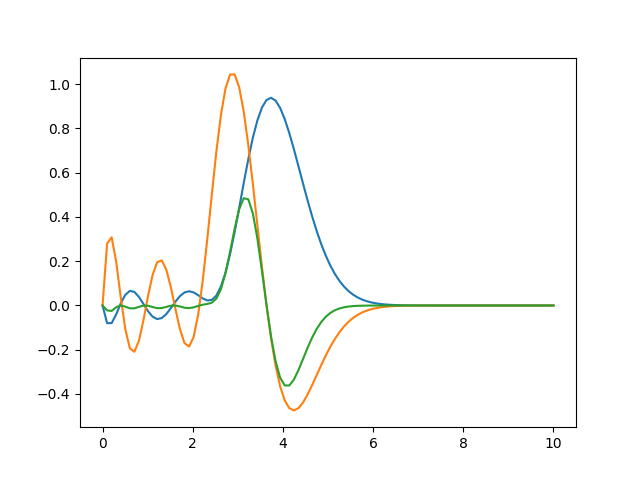

(-4.013456234019941e-14, 2.2724289119374817e-13)


In [11]:
# Visualizes the effect of the normalization
x = np.linspace(0,10,100)
plt.close()
# \tilde{R}_5 over r \in \[0,10\]
plt.plot(x, np.array([bf(r)[5] for r in x]))
# \tilde{R}_4 over r \in \[0,10\]
plt.plot(x, np.array([bf(r)[4] for r in x]))
# \tilde{R}_5 * \tilde{R}_4 over r \in \[0,10\]
plt.plot(x, np.array([bf(r)[5]*bf(r)[4] for r in x]))
plt.show()

bf_4_5 = lambda r: bf(r)[5]*bf(r)[4]
# should be equal 0 (numerical inaccuracies)
print(integrate.quad(bf_4_5, 0, 10))

In [12]:
# We start with <nα|X_i>
max_radial = 5
interaction_cutoff = 3.5
hypers = dict(soap_type="RadialSpectrum",
              interaction_cutoff=interaction_cutoff,
              max_radial=max_radial,
              max_angular=0,
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              )
soap = SOAP(**hypers)
SM = soap.transform(frames)
soap_coeff = SM.get_dense_feature_matrix(soap)
# soap_coeff shape is (number of envrionments, number of species * max_radial)
nb_envs = soap_coeff.shape[0]
nb_species = int(soap_coeff.shape[1]/max_radial)
# for one environment the order is (species, radial) e.g. for atomic structurre CH2 with max_radial = 3
# [(C, 0), (C, 1), ((C,2), (H_1,0), (H_1,1), (H_1,2), (H_2,0), (H_2,1), (H_2,2)]
print(nb_envs)
print(nb_species)
# \tilde{R}_n(r) for all n
basis_function = gto_basis_constant_function(max_radial, interaction_cutoff)
position_repr = lambda r : soap_coeff.dot( np.repeat(basis_function(r), nb_species) )

362
4


<IPython.core.display.Javascript object>


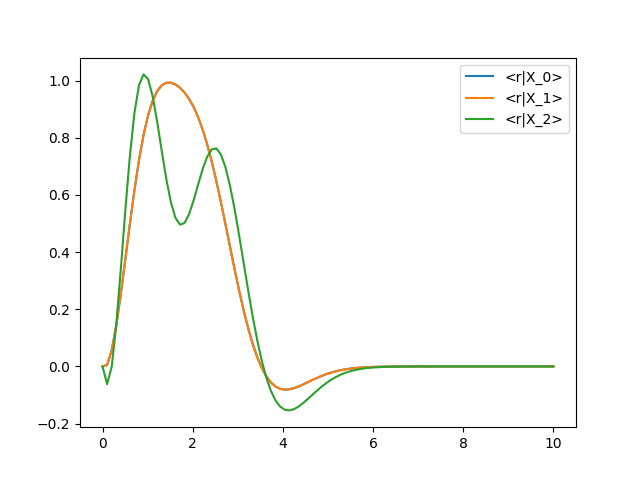

In [13]:
# Visualizes the effect of the normalization
x = np.linspace(0,10,100)
plt.close()
# <r|X_0>
plt.plot(x, np.array([position_repr(r)[0] for r in x]), label='<r|X_0>')
# <r|X_1> which is by accident = <r|X_0>
plt.plot(x, np.array([position_repr(r)[1] for r in x]), label='<r|X_1>')
# <r|X_2>
plt.plot(x, np.array([position_repr(r)[2] for r in x]), label='<r|X_2>')
plt.legend()
plt.show()

Now lets write this down in a more systematic way

In [ ]:
# computes the [\int \|<r|X_i>-<r|X_j>\|_2 dr]_{ij} matrix
def compute_statistical_euclidean_distance_matrix(frames, radial_basis="GTO", gaussian_sigma_type="Constant", gaussian_sigma_constant=0.4, max_radial=6, interaction_cutoff=3.5, integration_grid_size = 100):
    # We start with <nα|X_i>
    hypers = dict(soap_type="RadialSpectrum",
                  interaction_cutoff=interaction_cutoff,
                  max_radial=max_radial,
                  max_angular=0,
                  gaussian_sigma_constant=0.4,
                  gaussian_sigma_type="Constant",
                  cutoff_smooth_width=0.5,
                  )
    soap = SOAP(**hypers)
    SM = soap.transform(frames)
    soap_coeff = SM.get_dense_feature_matrix(soap)
    nb_envs = soap_coeff.shape[0]
    nb_species = int(soap_coeff.shape[1]/max_radial)
    basis_function = gto_basis_constant_function(max_radial, interaction_cutoff)
    position_repr = lambda r : soap_coeff.dot( np.repeat(basis_function(r), nb_species) )
    
    # [<r|X_i>]_{ir} matrix
    integration_grid_eval = np.zeros((nb_envs, integration_grid_size))
    integration_grid = np.linspace(0,interaction_cutoff,integration_grid_size)
    for i in range(len(integration_grid)):
        integration_grid_eval[:,i] = position_repr(integration_grid[i])
    
    # This step is quite slow
    # [\int \|<r|X_i>-<r|X_j>\|_2 dr]_{ij} matrix    
    integration_grid_eval_diff = np.zeros((nb_envs, nb_envs))
    for i in range(nb_envs):
        if i % 100 == 0: print(i)
        for j in range(nb_envs):
            # \|<r|X_i>-<r|X_j>\|_2 for r in grid 
            tmp = np.linalg.norm((integration_grid_eval[i,:]-integration_grid_eval[j,:])[:,np.newaxis], axis=1)
            integration_grid_eval_diff[i,j] = scipy.integrate.simps(tmp, integration_grid)
    return integration_grid_eval_diff

In [ ]:
#integration_grid_eval_diff = compute_statistical_euclidean_distance_matrix(frames)
#print(integration_grid_eval_diff)

In [29]:
from scipy.special import gamma
from scipy import integrate

# N_n
def orthogonal_normalization(n, sigma):
    return np.sqrt( 2/(sigma**(2*n+3) *gamma(n+3/2)) )

# (S_nndash)^(-1/2)
def orthonormalization(n, b, N, sigma):
    ndash = n[:,np.newaxis]
    bdash = b[:,np.newaxis]
    sigmadash = sigma[:,np.newaxis]
    Ndash = N[:,np.newaxis]
    overlap = 0.5*N*Ndash*(b+bdash)**(-0.5*(3+n+ndash))*gamma(0.5*(3+n+ndash))
    return scipy.linalg.fractional_matrix_power(overlap,-0.5)
    
# R_n(r)*r
def gaussian_sigma_constant(N, b, n, r):
    return N * r**(n+1) * np.exp(-b*r**2)

# \tilde{R}_n(r)
def gto_basis_constant_function(max_n, cutoff):
    n = np.arange(max_n)
    sigma = np.sqrt(np.hstack((1,np.arange(1,max_n)))) * cutoff / max_n
    N = orthogonal_normalization(n, sigma)
    b = 1/(2*sigma)
    Snorm = orthonormalization(n, b, N, sigma)
    return lambda r : gaussian_sigma_constant(N, b, n, r).dot(Snorm)


# computes the [<r|X_i>]_{ir} matrix where r is on a grid
def compute_position_representation_on_grid(frames, radial_basis="GTO", gaussian_sigma_type="Constant", gaussian_sigma_constant=0.4, max_radial=6, interaction_cutoff=3.5, integration_grid_size = 100):
    # We start with <nα|X_i>
    hypers = dict(soap_type="RadialSpectrum",
                  interaction_cutoff=interaction_cutoff,
                  max_radial=max_radial,
                  max_angular=0,
                  gaussian_sigma_constant=0.4,
                  gaussian_sigma_type="Constant",
                  cutoff_smooth_width=0.5,
                  )
    soap = SOAP(**hypers)
    SM = soap.transform(frames)
    soap_coeff = SM.get_dense_feature_matrix(soap)
    nb_envs = soap_coeff.shape[0]
    nb_species = int(soap_coeff.shape[1]/max_radial)
    basis_function = gto_basis_constant_function(max_radial, interaction_cutoff)
    position_repr = lambda r : soap_coeff.dot( np.repeat(basis_function(r), nb_species) )
    
    # [<r|X_i>]_{ir} matrix (envs, gridsize)
    integration_grid_eval = np.zeros((nb_envs, integration_grid_size))
    integration_grid = np.linspace(0,interaction_cutoff,integration_grid_size)
    for i in range(len(integration_grid)):
        integration_grid_eval[:,i] = position_repr(integration_grid[i])
    return (integration_grid_eval, integration_grid)
    
# structure_ranges : ids of the environments in the frames used for the precomputation
def compute_structure_ranges(frames):
    # e.g. A_0 = frames[structure_ranges_index[0]:structure_ranges_index[1]];
    #      A_1 = frames[structure_ranges_index[1]:structure_ranges_index[2]]; ...
    structure_ranges_index = [0] * (len(frames)+1)
    for i in range(len(frames)):    
        structure_ranges_index[i+1] = frames[i].get_number_of_atoms() + structure_ranges_index[i]
    structure_ranges = []
    for i in range(len(structure_ranges_index)-1):
        structure_ranges.append(list(range(structure_ranges_index[i],structure_ranges_index[i+1])))
    return structure_ranges

# this is a workaround to identifiy the structures from the soap coeffs
# d(A,B) = [\int \|<r|X_i>-<r|X_j>\|_2 dr]_{X_i\in A, X_j\in B} 
def compute_distance_between_structures(struc_A, struc_B, integration_grid_eval, integration_grid):
    # This step is quite slow
    # [\int \|<r|X_i>-<r|X_j>\|_2 dr]_{ij} matrix
    integration_grid_eval_diff = np.zeros((len(struc_A), len(struc_B)))
    # X_i = struc_A[i]
    for i in range(len(struc_A)):
        for j in range(len(struc_B)):
            # \|<r|X_i>-<r|X_j>\|_2 for r in grid
            tmp = np.linalg.norm((integration_grid_eval[struc_A[i],:]-integration_grid_eval[struc_B[j],:])[:,np.newaxis], axis=1)
            integration_grid_eval_diff[i,j] = scipy.integrate.simps(tmp, integration_grid)
    return integration_grid_eval_diff

def compute_structure_kernel(kernel_function, structure_ranges1, structure_ranges2, integration_grid_eval_diff, integration_grid):
    struc_kernel = np.zeros((len(structure_ranges1),len(structure_ranges2)))
    for i in range(len(structure_ranges1)):
        for j in range(len(structure_ranges2)):
            print("(A_i,B_j)",i,j)
            struc_kernel[i,j] = compute_structure_kernel_entry(kernel_function, structure_ranges1[i], structure_ranges2[j], integration_grid_eval_diff, integration_grid)
    return struc_kernel
        
def compute_structure_kernel_entry(kernel_function, struc_A, struc_B, integration_grid_eval_diff, integration_grid):
    return kernel_function( compute_distance_between_structures(struc_A, struc_B,
                                                                integration_grid_eval_diff, integration_grid) )


In [30]:
#frames = read('./data/CSD-500.xyz','0:10')
## wraps the structures into the unit cell
#for i in range(len(frames)):
#    frames[i].wrap(eps=1e-11)

#sigma = 0.5
#kernel_function = lambda distances : np.mean(np.exp(-0.5*distances/sigma**2))
                                             
#integration_grid_eval_diff, integration_grid = compute_position_representation_on_grid(frames)
#structure_ranges = compute_structure_ranges(frames)
                                             
#kernel_train = compute_structure_kernel(kernel_function, [structure_ranges[0]], [structure_ranges[1]], integration_grid_eval_diff, integration_grid)

In [31]:
class KRR(object):
    def __init__(self, frames, sigma=0.5):
        self.sigma = sigma
        self.kernel_function = lambda distances : np.mean(np.exp(-0.5*distances/self.sigma**2))
        self.integration_grid_eval_diff, self.integration_grid = compute_position_representation_on_grid(frames)
        self.structure_ranges = compute_structure_ranges(frames)
        self.weights = None
        
    def apply_icdf(self):
        self.integration_grid_eval_diff = np.sort(self.integration_grid_eval_diff, axis=1)
        
    def compute_kernel(self, structures1_ids, structures2_ids):
        structures1 = [self.structure_ranges[struc_id] for struc_id in structures1_ids]
        structures2 = [self.structure_ranges[struc_id] for struc_id in structures2_ids]
        return compute_structure_kernel(self.kernel_function, structures1, structures2,
                                        self.integration_grid_eval_diff, self.integration_grid)
    
    # train_labels: y 
    def compute_weights(self, structures_train_ids, train_labels, Lambda=0.5, jitter=1e-8):
        self.structures_train_ids = structures_train_ids
        # X_train
        kernel_train = self.compute_kernel(self.structures_train_ids, self.structures_train_ids)
        # adjust the kernel so that it is properly scaled
        delta = np.std(train_labels) / np.mean(kernel_train.diagonal())
        kernel_train[np.diag_indices_from(kernel_train)] += Lambda**2 / delta **2 + jitter
        print("Kernel computed")
        # train the krr model, w = (K_train + lambda*I)^(-1)y
        self.weights = np.linalg.solve(kernel_train, train_labels)
        
    def predict(self, structures_test_ids):
        print("structures_test_ids", structures_test_ids)
        kernel_test = self.compute_kernel(self.structures_train_ids, structures_test_ids)
        return np.dot(self.weights, kernel_test)

In [32]:
def split_dataset(N, test_fraction, seed=10):
    ids = np.arange(N)
    np.random.seed(seed)
    np.random.shuffle(ids)
    Ntrain = int(N*test_fraction)
    train_ids = ids[:Ntrain]
    test_ids = ids[Ntrain:]
    return train_ids, test_ids
def get_mae(ypred,y):
    return np.mean(np.abs(ypred-y))
def get_rmse(ypred,y):
    return np.sqrt(np.mean((ypred-y)**2))
def get_sup(ypred,y):
    return np.amax(np.abs((ypred-y)))
def get_r2(y_pred,y_true):
    weight = 1
    sample_weight = None
    numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,dtype=np.float64)
    denominator = (weight * (y_true - np.average(
        y_true, axis=0, weights=sample_weight)) ** 2).sum(axis=0,dtype=np.float64)
    output_scores = 1 - (numerator / denominator)
    return np.mean(output_scores)

score_func = dict(
    MAE=get_mae,
    RMSE=get_rmse,
    SUP=get_sup,
    R2=get_r2,
)

def get_score(ypred,y):
    scores = {}
    for k,func in score_func.items():
        scores[k] = func(ypred,y)
    return scores

In [28]:
# prepare data and labels

# data
#nbs_frames = [10, 100, 200, 300, 400, 500] 
nbs_frames = [5, 10]
scores = []
scores_icdf = []
for nb_frames in nbs_frames:
    print("nb_frames", nb_frames)
    frames = read('./data/CSD-500.xyz','0:'+str(nb_frames))
    # wraps the structures into the unit cell
    for i in range(len(frames)):
        frames[i].wrap(eps=1e-11)

    # labels
    n_atoms = sum(frame.get_number_of_atoms() for frame in frames)
    chem_shifts = []
    for frame in frames:
        chem_shifts.append(frame.arrays['CS'])
    chem_shifts_atoms = np.concatenate(chem_shifts, axis=0)
    chem_shifts_atoms_mean = np.mean(chem_shifts_atoms, axis=1)

    train_ids, test_ids = split_dataset(len(frames), 0.4)
    train_chem_shifts = chem_shifts_atoms_mean[train_ids] 
    test_chem_shifts = chem_shifts_atoms_mean[train_ids]

    # create and train model
    print("L2 norm method")
    model = KRR(frames)
    model.compute_weights(train_ids, train_chem_shifts)
    print("weights computed")    
    pred = model.predict(test_ids)
    scores.append(get_score(pred, chem_shifts_atoms_mean[test_ids]))
    
    print("wasserstein method")
    model = KRR(frames)
    model.apply_icdf()
    model.compute_weights(train_ids, train_chem_shifts)    
    print("weights computed")    
    pred = model.predict(test_ids)
    scores_icdf.append(get_score(pred, chem_shifts_atoms_mean[test_ids]))

nb_frames 5
L2 norm method
len(frames) 5
(A_i,B_j) 0 0
len(struc_A) 108
integration_grid_eval.shape (678, 100)
(A_i,B_j) 0 1
len(struc_A) 108
integration_grid_eval.shape (678, 100)
(A_i,B_j) 1 0
len(struc_A) 168
integration_grid_eval.shape (678, 100)
(A_i,B_j) 1 1
len(struc_A) 168
integration_grid_eval.shape (678, 100)


/home/alexgo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


Kernel computed
weights computed
structures_test_ids [0 4 1]
(A_i,B_j) 0 0
len(struc_A) 108
integration_grid_eval.shape (678, 100)
(A_i,B_j) 0 1
len(struc_A) 108
integration_grid_eval.shape (678, 100)
(A_i,B_j) 0 2
len(struc_A) 108
integration_grid_eval.shape (678, 100)
(A_i,B_j) 1 0
len(struc_A) 168
integration_grid_eval.shape (678, 100)
(A_i,B_j) 1 1
len(struc_A) 168
integration_grid_eval.shape (678, 100)
(A_i,B_j) 1 2
len(struc_A) 168
integration_grid_eval.shape (678, 100)
wasserstein method
len(frames) 5
(A_i,B_j) 0 0
len(struc_A) 108
integration_grid_eval.shape (678, 100)
(A_i,B_j) 0 1
len(struc_A) 108
integration_grid_eval.shape (678, 100)
(A_i,B_j) 1 0
len(struc_A) 168
integration_grid_eval.shape (678, 100)
(A_i,B_j) 1 1
len(struc_A) 168
integration_grid_eval.shape (678, 100)
Kernel computed
weights computed
structures_test_ids [0 4 1]
(A_i,B_j) 0 0
len(struc_A) 108
integration_grid_eval.shape (678, 100)
(A_i,B_j) 0 1
len(struc_A) 108
integration_grid_eval.shape (678, 100)
(A_i,

<IPython.core.display.Javascript object>


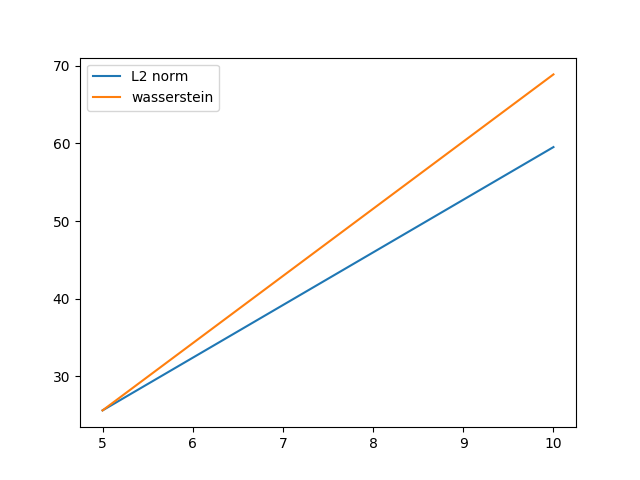

In [36]:
rmse = [score['RMSE'] for score in scores]
rmse_icdf = [score['RMSE'] for score in scores_icdf]
plt.close()
plt.plot(nbs_frames, rmse, label='L2 norm')
plt.plot(nbs_frames, rmse_icdf, label='wasserstein')
plt.legend()
plt.show()

In [197]:
frames = read('./data/CSD-500.xyz','0:5')
nb = 0
for i in range(len(frames)):
    nb = nb + frames[i].get_number_of_atoms()
print(nb)

678


In [175]:
# nearly perfect
get_score(chem_shifts_atoms_mean[test_ids]+np.random.rand(len(test_ids))*0.25, chem_shifts_atoms_mean[test_ids])

{'MAE': 0.12725944849574233,
 'RMSE': 0.12999884014574606,
 'SUP': 0.16853340376658466,
 'R2': 0.9999955129136372}

In [176]:
frames = read('./data/CSD-500.xyz',':')
print(len(frames))

500


In [9]:
n_atoms = sum(frame.get_number_of_atoms() for frame in frames)
chem_shifts = []
for frame in frames:
    chem_shifts.append(frame.arrays['CS'])
chem_shifts_atoms = np.concatenate(chem_shifts, axis=0)
chem_shifts_atoms_mean = np.mean(chem_shifts_atoms, axis=1)

# SOAP: Power spectrum

In [262]:
soap.get_num_coefficients()

6

In [51]:
%time representation = soap.transform(frames)

CPU times: user 10.6 ms, sys: 0 ns, total: 10.6 ms
Wall time: 9.77 ms


In [52]:
X = representation.get_dense_feature_matrix(soap).T

In [53]:
X.shape

(24, 362)

# Learning the chemical shifts of a set of crystal structures

## learning utilities

In [ ]:
class KRR(object):
    def __init__(self,integration_grid, integration_grid_eval):
        self.integration_grid = integration_grid
        self.integration_grid_eval = integration_grid_eval
        
    def predict(self,frames):
        features = compute_representation(self.representation,frames)
        kernel = compute_atomic_kernel(self.zeta, self.X, features)
        return np.dot(self.weights, kernel)

def compute_atomic_kernel(zeta, rep1, rep2=None):
    if rep2 is not None:
        kernel = rep1.cosine_kernel_atomic(rep2, zeta)
    else:
        kernel = rep1.cosine_kernel_atomic(zeta)
    return kernel   

def train_krr_model(zeta,Lambda,representation,frames,y,jitter=1e-8):
    features = compute_representation(representation, frames)
    kernel = compute_atomic_kernel(zeta, features, features)    
    # adjust the kernel so that it is properly scaled
    delta = np.std(y) / np.mean(kernel.diagonal())
    kernel[np.diag_indices_from(kernel)] += Lambda**2 / delta **2 + jitter
    # train the krr model
    weights = np.linalg.solve(kernel,y)
    model = KRR(zeta, weights,representation, features)
    return model,kernel


In [ ]:
n_atoms = sum(frame.get_number_of_atoms() for frame in frames)
chem_shifts = []
for frame in frames:
    chem_shifts.append(frame.arrays['CS'])
chem_shifts_atoms = np.concatenate(chem_shifts, axis=0)

In [98]:
def compute_atomic_kernel(zeta, rep1, rep2=None):
    if rep2 is not None:
        kernel = rep1.cosine_kernel_atomic(rep2, zeta)
    else:
        kernel = rep1.cosine_kernel_atomic(zeta)
    return kernel

def extract_energy(frames):
    prop = [[]]*len(frames)
    for ii,cc in enumerate(frames):
        #prop[ii] = cc.info['dft_formation_energy_per_atom_in_eV']
        prop[ii] = cc.info['ENERGY']
    y = np.array(prop)
    return y

def split_dataset(frames, test_fraction, seed=10):
    N = len(frames)
    ids = np.arange(N)
    np.random.seed(seed)
    np.random.shuffle(ids)
    Ntrain = int(N*test_fraction)
    train = ids[:Ntrain]
    test = ids[Ntrain:]
    targets = extract_energy(frames)
    return [frames[ii] for ii in train],targets[train],[frames[ii] for ii in test],targets[test]

def get_mae(ypred,y):
    return np.mean(np.abs(ypred-y))
def get_rmse(ypred,y):
    return np.sqrt(np.mean((ypred-y)**2))
def get_sup(ypred,y):
    return np.amax(np.abs((ypred-y)))
def get_r2(y_pred,y_true):
    weight = 1
    sample_weight = None
    numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,dtype=np.float64)
    denominator = (weight * (y_true - np.average(
        y_true, axis=0, weights=sample_weight)) ** 2).sum(axis=0,dtype=np.float64)
    output_scores = 1 - (numerator / denominator)
    return np.mean(output_scores)


score_func = dict(
    MAE=get_mae,
    RMSE=get_rmse,
    SUP=get_sup,
    R2=get_r2,
)

def get_score(ypred,y):
    scores = {}
    for k,func in score_func.items():
        scores[k] = func(ypred,y)
    return scores

def train_krr_model(zeta,Lambda,representation,frames,y,jitter=1e-8):
    features = compute_representation(representation, frames)
    kernel = compute_atomic_kernel(zeta, features, features)    
    # adjust the kernel so that it is properly scaled
    delta = np.std(y) / np.mean(kernel.diagonal())
    kernel[np.diag_indices_from(kernel)] += Lambda**2 / delta **2 + jitter
    # train the krr model
    weights = np.linalg.solve(kernel,y)
    model = KRR(zeta, weights,representation, features)
    return model,kernel


## With the full power spectrum

In [ ]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=1, 
              max_angular=1, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              )
soap = SOAP(**hypers)

In [ ]:
frames_train, y_train, frames_test, y_test = split_dataset(frames,0.5)

In [ ]:
y_train = np.concatenate([frame.arrays['CS'] for frame in frames_train], axis=0)

In [ ]:
y_train = y_train[:,0]

In [ ]:
y_test = np.concatenate([frame.arrays['CS'] for frame in frames_test], axis=0)

In [ ]:
y_test = y_test[:,0]

In [ ]:
n_atoms = sum(frame.get_number_of_atoms() for frame in frames_train)

In [ ]:
zeta = 2

In [ ]:
features = compute_representation(soap, frames_train)

In [ ]:
features

In [ ]:
kernel = compute_atomic_kernel(zeta, features, features)

In [ ]:
kernel.shape

In [ ]:
# WTF?
#for i in range(len(kernel)):
#    kernel[i][0] = np.sqrt(i)/50

In [ ]:
kernel[191]

In [ ]:
# First, try without regularization -- the results will be nonsense
weights = np.linalg.solve(kernel,y_train)

In [ ]:
weights.shape

In [ ]:
model = KRR(zeta, weights, soap, features)

In [ ]:
y_pred = model.predict(frames_test)
get_score(y_pred, y_test)

In [ ]:
zeta = 2
Lambda = 10
krr,k = train_krr_model(zeta, Lambda, soap, frames_train, y_train)

In [ ]:
y_pred = krr.predict(frames_test)
get_score(y_pred, y_test)

In [ ]:
#sc = plt.scatter(y_pred, y_test, s=3)
#ax = plt.axis('scaled')
plt.plot(y_test, y_pred, '.')
plt.ylabel('DFT shift')
plt.xlabel('Predicted shift')
plt.savefig('R1.png', dpi=300)

## With just the radial spectrum

In [43]:
hypers = dict(soap_type="RadialSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=0, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5
              )
soap = SOAP(**hypers)

In [44]:
frames_train, y_train, frames_test, y_testr = split_dataset(frames,0.4)

NameError: name 'split_dataset' is not defined

In [45]:
zeta = 2
Lambda = 5e-3
krr,k = train_krr_model(zeta, Lambda, soap, frames_train, y_train)

NameError: name 'train_krr_model' is not defined

In [ ]:
y_predr = krr.predict(frames_test)
get_score(y_predr, y_testr)

In [ ]:
#plt.scatter(y_predr, y_testr, s=3)
#plt.scatter(y_predr, y_testr, s=3)
#ax = plt.axis('scaled')
plt.plot(y_pred, y_test, '.b')
plt.plot(y_predr, y_testr, '.y')
plt.legend(['Full','Radial'])
plt.ylabel('DFT energy / (eV/atom)')
plt.xlabel('Predicted energy / (eV/atom)')
plt.savefig('R1.png', dpi=300)

# Make a map of the dataset

## utils

In [ ]:
def compute_representation(representation,frames):
    expansions = soap.transform(frames)
    return expansions

def compute_kernel(zeta, rep1, rep2=None):
    if rep2 is None:
        kernel = rep1.cosine_kernel_global(zeta)
    else:
        kernel = rep1.cosine_kernel_global(rep2,zeta)
    return kernel

In [ ]:
def link_ngl_wdgt_to_ax_pos(ax, pos, ngl_widget):
    from matplotlib.widgets import AxesWidget
    from scipy.spatial import cKDTree
    r"""
    Initial idea for this function comes from @arose, the rest is @gph82 and @clonker
    """
    
    kdtree = cKDTree(pos)        
    #assert ngl_widget.trajectory_0.n_frames == pos.shape[0]
    x, y = pos.T
    
    lineh = ax.axhline(ax.get_ybound()[0], c="black", ls='--')
    linev = ax.axvline(ax.get_xbound()[0], c="black", ls='--')
    dot, = ax.plot(pos[0,0],pos[0,1], 'o', c='red', ms=7)

    ngl_widget.isClick = False
    
    def onclick(event):
        linev.set_xdata((event.xdata, event.xdata))
        lineh.set_ydata((event.ydata, event.ydata))
        data = [event.xdata, event.ydata]
        _, index = kdtree.query(x=data, k=1)
        dot.set_xdata((x[index]))
        dot.set_ydata((y[index]))
        ngl_widget.isClick = True
        ngl_widget.frame = index
    
    def my_observer(change):
        r"""Here comes the code that you want to execute
        """
        ngl_widget.isClick = False
        _idx = change["new"]
        try:
            dot.set_xdata((x[_idx]))
            dot.set_ydata((y[_idx]))            
        except IndexError as e:
            dot.set_xdata((x[0]))
            dot.set_ydata((y[0]))
            print("caught index error with index %s (new=%s, old=%s)" % (_idx, change["new"], change["old"]))
    
    # Connect axes to widget
    axes_widget = AxesWidget(ax)
    axes_widget.connect_event('button_release_event', onclick)
    
    # Connect widget to axes
    ngl_widget.observe(my_observer, "frame", "change")

## make a map with kernel pca projection

In [ ]:
# Load the small molecules 
frames = read('./data/small_molecules-1000.xyz',':600')

In [ ]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=6, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              )
soap = SOAP(**hypers)

In [ ]:
zeta = 2

features = compute_representation(soap, frames)

kernel = compute_kernel(zeta,features)

In [ ]:
from sklearn.decomposition import KernelPCA

In [ ]:
kpca = KernelPCA(n_components=2,kernel='precomputed')
kpca.fit(kernel)

In [ ]:
X = kpca.transform(kernel)

In [ ]:
plt.scatter(X[:,0],X[:,1],s=3)
#plt.savefig('PCA.png',dpi=300)

## make an interactive map

In [ ]:
# package to visualize the structures in the notebook
# https://github.com/arose/nglview#released-version
import nglview

In [ ]:
iwdg = nglview.show_asetraj(frames)
# set up the visualization
iwdg.add_unitcell()
iwdg.add_spacefill()
iwdg.remove_ball_and_stick()
iwdg.camera = 'orthographic'
iwdg.parameters = { "clipDist": 0 }
iwdg.center()
iwdg.update_spacefill(radiusType='covalent',
                                   scale=0.6,
                                   color_scheme='element')
iwdg._remote_call('setSize', target='Widget',
                               args=['%dpx' % (600,), '%dpx' % (400,)])
iwdg.player.delay = 200.0

In [ ]:
link_ngl_wdgt_to_ax_pos(plt.gca(), X, iwdg)
plt.scatter(X[:,0],X[:,1],s=3)
iwdg